<a href="https://colab.research.google.com/github/MathBioCU/WSINDy4Atmos/blob/main/get_barotropic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[PyQG read the docs](https://pyqg.readthedocs.io/en/latest/index.html)
\
[PyQG Github](https://github.com/pyqg/pyqg/tree/master/examples)

# PyQG Installation

In [ ]:
# Get conda installer
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [ ]:
!conda --version

# Import dependencies
import numpy as np
import cython

conda 23.11.0


In [ ]:
# Install PyQG
!conda install -c conda-forge pyqg

In [ ]:
import pyqg
import pyfftw
import matplotlib.pyplot as plt

In [ ]:
#!pip install xarray
import xarray

In [ ]:
# Access your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directories
%cd /content/drive/My Drive/WSINDy

Mounted at /content/drive
/content/drive/My Drive/WSINDy


# Original Barotropic Data

In [ ]:
# create the model object
m = pyqg.BTModel(L=2.*np.pi, nx=256,
                 beta=0., H=1., rek=0., rd=None,
                 tmax=20, dt=0.001, taveint=1,
                 ntd=4)
# in this example we used ntd=4, four threads
# if your machine has more (or fewer) cores available, you could try changing it

INFO:  Logger initialized


In [ ]:
# generate McWilliams 84 IC condition

fk = m.wv != 0
ckappa = np.zeros_like(m.wv2)
ckappa[fk] = np.sqrt( m.wv2[fk]*(1. + (m.wv2[fk]/36.)**2) )**-1

nhx,nhy = m.wv2.shape

Pi_hat = np.random.randn(nhx,nhy)*ckappa +1j*np.random.randn(nhx,nhy)*ckappa

Pi = m.ifft( Pi_hat[np.newaxis,:,:] )
Pi = Pi - Pi.mean()
Pi_hat = m.fft( Pi )
KEaux = m.spec_var( m.wv*Pi_hat )

pih = ( Pi_hat/np.sqrt(KEaux) )
qih = -m.wv2*pih
qi = m.ifft(qih)

In [ ]:
type(qi), qi.shape

(numpy.ndarray, (1, 256, 256))

In [ ]:
# initialize the model with that initial condition
m.set_q(qi)

In [ ]:
import matplotlib.pyplot as plt

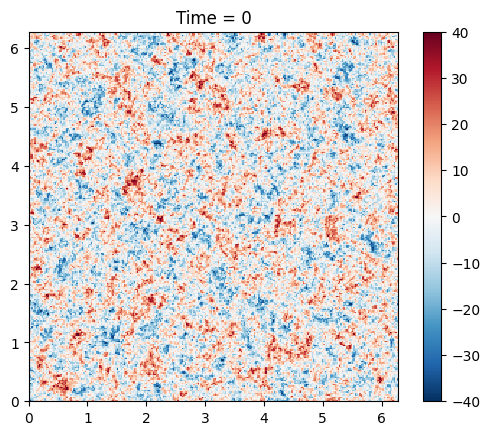

In [ ]:
# define a quick function for plotting and visualize the initial condition
def plot_q(m, qmax=40):
  fig, ax = plt.subplots()
  pc = ax.pcolormesh(m.x,m.y,m.q.squeeze(), cmap='RdBu_r')
  pc.set_clim([-qmax, qmax])
  ax.set_xlim([0, 2*np.pi])
  ax.set_ylim([0, 2*np.pi]);
  ax.set_aspect(1)
  plt.colorbar(pc)
  plt.title('Time = %g' % m.t)
  plt.show()

plot_q(m)

In [ ]:
# solution storage
W = []
U = []
V = []

for _ in m.run_with_snapshots(tsnapstart=0, tsnapint=125*m.dt):
  plot_q(m)
  W.append(m.q.squeeze().copy())
  U.append(m.ufull.squeeze().copy())
  V.append(m.vfull.squeeze().copy())
  # U.append(m.u.squeeze().copy()) # Velocity anomalies
  # V.append(m.v.squeeze().copy())

In [ ]:
# Change directories
%cd /content/drive/My Drive/WSINDy/PyQuasiGeostrophic

/content/drive/My Drive/WSINDy/PyQuasiGeostrophic


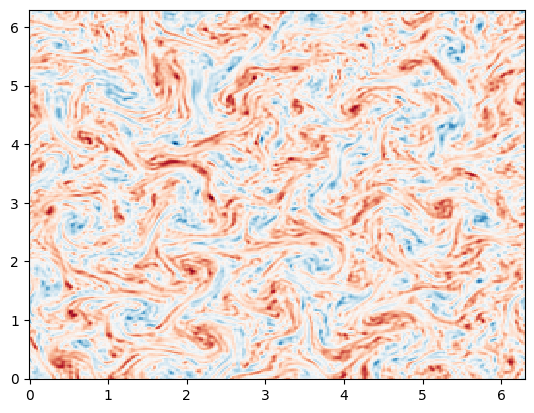

In [ ]:
W_ds = np.stack(W, axis=-1)
W_ds.shape

thyme = 3

fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 256)
y = np.linspace(0, 2*np.pi, 256)
ax.pcolormesh(x, y, W_ds[:,:,thyme], cmap='RdBu_r')
plt.show()

# Reshape to export
W_csv = W_ds.reshape((256**2,160))

# Export as csv
np.savetxt("geostrophic_W.csv", W_csv, delimiter=",")

In [ ]:
x = np.linspace(0, 2*np.pi, 256)
y = np.linspace(0, 2*np.pi, 256)

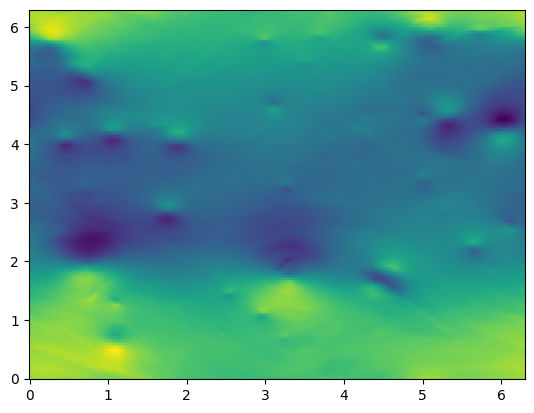

In [ ]:
U_ds = np.stack(U, axis=-1)
U_ds.shape

fig, ax = plt.subplots()
ax.pcolormesh(x, y, U_ds[:,:,-1])
plt.show()

# Reshape to export
U_csv = U_ds.reshape((256**2,160))

# Export as csv
np.savetxt("geostrophic_U.csv", U_csv, delimiter=",")

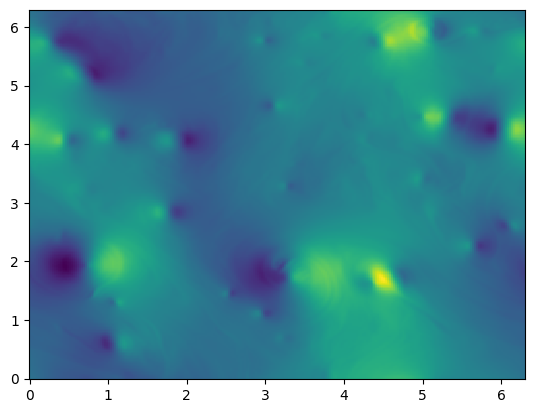

In [ ]:
V_ds = np.stack(V, axis=-1)
V_ds.shape

fig, ax = plt.subplots()
ax.pcolormesh(x, y, V_ds[:,:,-1])
plt.show()

# Reshape to export
V_csv = V_ds.reshape((256**2,160))

# Export as csv
np.savetxt("geostrophic_V.csv", V_csv, delimiter=",")

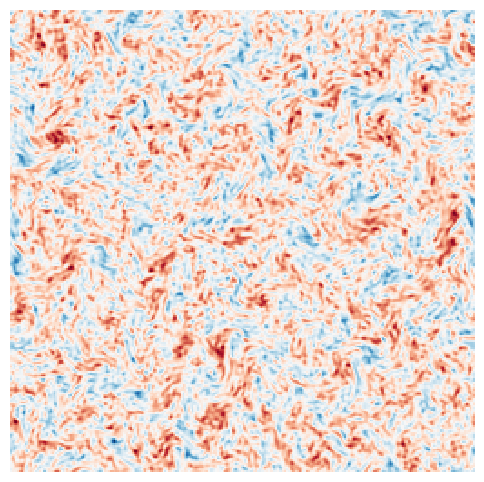

In [ ]:
# MAKE A MOVIE
from matplotlib.animation import FuncAnimation

plt.rcParams['figure.figsize'] = [6, 6]
fig, ax = plt.subplots()
ax.set_axis_off()
#X, Y = np.meshgrid(x, y)
pcm = ax.pcolormesh(x, y, W_ds[:,:,0], cmap='RdBu_r')
plt.show()

def movie_update(t):
  pcm.set_array(W_ds[:,:,t].ravel())
  return [pcm]

ani = FuncAnimation(fig, movie_update, frames=160, blit=True)
ani.save('animation.mp4', writer='ffmpeg', fps=24, dpi=300)